In [1]:
import glob
from Bio.SeqIO import parse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple
from jellyfish import hamming_distance

Prototyping error correction methods
===

Load sequence data
---

Directory containing `fastq` files:

In [2]:
data_dir = '/Users/williamdewitt/Downloads'

List of `collapse-unique.fastq` files (one per sample)

In [3]:
files = glob.glob(f'{data_dir}/unique_*_collapse-unique.fastq')
files

['/Users/williamdewitt/Downloads/unique_P1_collapse-unique.fastq']

Using just one sample, parse into a `pandas.DataFrame` with sequence and abundance columns

In [4]:
df = pd.DataFrame([(str(seq.seq), int(seq.id.split('|')[3].split('=')[1]))
                    for seq in parse(files[0], 'fastq')],
                  columns=('sequence', 'abundance'))
df

,sequence,abundance
0,NNNNNNNNNNNNNNNNNNNNNNNGCCTCTGGATTCACCTTCAGTAG...,1
1,NNNNNNNNNNNNNNNNNNNNNNNNGACATCTACGTTGATTCTTTCA...,1965
2,NNNNNNNNNNNNNNNNNNNNNNNNGCTGTCTATGGTGGGTCCTTCA...,2037
3,NNNNNNNNNNNNNNNNNNNNNNNNGACCCTCACGCTGACCTGCACC...,1
4,NNNNNNNNNNNNNNNNNNNNNNNNATTGTCTCTAGTGGCTCCATCA...,1
...,...,...
296894,NNNNNNNNNNNNNNNNNNNNNNNNTCTCTAGCAACGGTGCTACTTG...,1
296895,NNNNNNNNNNNNNNNNNNNNNNNNAGTGTCTCTGGTGGCTCTGTCA...,1
296896,NNNNNNNNNNNNNNNNNNNNNNNGCCTCTGGATTCGCCTTTAGCAC...,1
296897,NNNNNNNNNNNNNNNNNNNNNNNNACTGTCTCTGGTGGCTCCATCA...,1


Abundance distribution
---

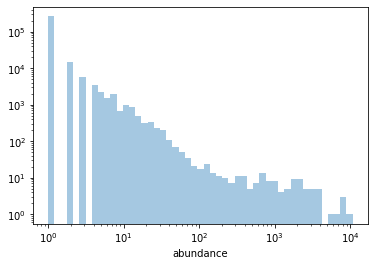

In [5]:
bins = np.logspace(0, np.log10(df.abundance.max()), 50)
sns.distplot(df.abundance, kde=False, bins=bins)
plt.xscale('log')
plt.yscale('log')
plt.show()

Error correction based on Hamming distance and relative abundance
---

In [6]:
def correct(df: pd.DataFrame,
            abundance_ratio_threshold: np.float32 = 1000,
            distance_threshold: np.float32 = 1,
            passes: int = 1, this_pass=1) -> Tuple[np.ndarray, np.ndarray]:
    
    print(f'error correction pass {this_pass}')
    
    df.sort_values(by='abundance', ascending=False, inplace=True)
    
    sequences = np.copy(df.sequence.values)
    abundances =  np.copy(df.abundance.values)
    
    unclustered = (abundances > 0)
    n_clustered = 0
    parent_idxs = np.where(df.abundance >= abundance_ratio_threshold)[0]

    for ct, i in enumerate(parent_idxs, 1):
        for j in i + 1 + np.where(unclustered[(i + 1):])[0]:
            abundance_ratio = abundances[i] / abundances[j]
            if (abundance_ratio > abundance_ratio_threshold 
                and len(sequences[i]) == len(sequences[j]) 
                and hamming_distance(sequences[i], sequences[j]) <= distance_threshold):
                abundances[i] += abundances[j]
                abundances[j] = 0
                unclustered[j] = False
                n_clustered += 1
        print(f'    parent sequence {ct} of {len(parent_idxs)}, {n_clustered} sequences clustered', end='    \r')
    print()
            
    nonzero_idxs = (abundances > 0)
    sequences = sequences[nonzero_idxs]
    abundances = abundances[nonzero_idxs]
    df_new = pd.DataFrame(np.array([sequences, abundances]).T,
                          columns=('sequence', 'abundance'))
    df_new.sort_values(by='abundance', ascending=False, inplace=True)

    if passes == 1:
        return df_new
    else:
        return correct(df_new,
                       abundance_ratio_threshold, distance_threshold,
                       passes - 1, this_pass + 1)

In [13]:
df_corrected = correct(df, abundance_ratio_threshold=100, distance_threshold=5, passes=3)

error correction pass 1
    parent sequence 188 of 188, 217860 sequences clustered    
error correction pass 2
    parent sequence 188 of 188, 1057 sequences clustered      
error correction pass 3
    parent sequence 174 of 174, 18 sequences clustered    


Abundance distribution before and after error correction
---

unique sequences before error correction: 296899
unique sequences after error correction: 77964
singleton composition before error correction: 41.66%
singleton composition after error correction: 12.03%


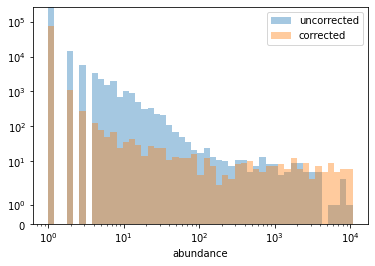

In [15]:
print(f'unique sequences before error correction: {len(df)}')
print(f'unique sequences after error correction: {len(df_corrected)}')
print(f'singleton composition before error correction: {df.abundance[df.abundance == 1].sum() / df.abundance.sum():.2%}')
print(f'singleton composition after error correction: {df_corrected.abundance[df_corrected.abundance == 1].sum() / df_corrected.abundance.sum():.2%}')
sns.distplot(df.abundance, kde=False, bins=bins, label='uncorrected')
sns.distplot(df_corrected.abundance, kde=False, bins=bins, label='corrected')
plt.xscale('log')
plt.yscale('symlog')
plt.legend()
plt.show()